## Installing libraries

## Importing libs

In [256]:
import requests
from scrapy import Selector
from bs4 import BeautifulSoup as bs
import pandas as pd

## Selectors

In [345]:
inova_url = 'https://www.inovacaotecnologica.com.br/noticias/meta.php?meta=Baterias&base='

In [352]:
get_url = [requests.get(url) for i in (inova_url+str(i) for i in range(0, 150, 15))]

In [381]:
def df_url(selector, col, get_url=get_url):
    content = get_url.content.decode('latin-1')
    sel = Selector(text=content)
    if col == 'data' or 'title':
        data = sel.css(selector).extract()
#    elif col == 'link':
#        data = sel.xpath(selector).extract()
    df = pd.DataFrame({
        col: data,
                  })
    return(df)

In [382]:
data = pd.concat([df_url('.data::text', 'data', teste[i]) for i in range(0,10)]).reset_index().drop("index", axis=1)

In [383]:
title = pd.concat([df_url('h2 *::text', 'title', teste[i]) for i in range(0,10)]).reset_index().drop("index", axis=1)

In [389]:
df = pd.concat([data, title], axis=1)

## A little bit of text processing

In [391]:
# visualize the most mentioned features

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

def word_cloud_figure(col,
            max_words=None,
            background_color='white',
            stopwords=None):
    string_text = str(col)
    wordCloud = WordCloud(max_words=max_words,
                        repeat=False,
                        stopwords=stopwords,
                        background_color=background_color
                        ).generate(string_text)
    plt.figure(figsize=(10,7))
    plt.imshow(wordCloud, interpolation='bilinear')
    plt.axis('off')
    return(plt.show())

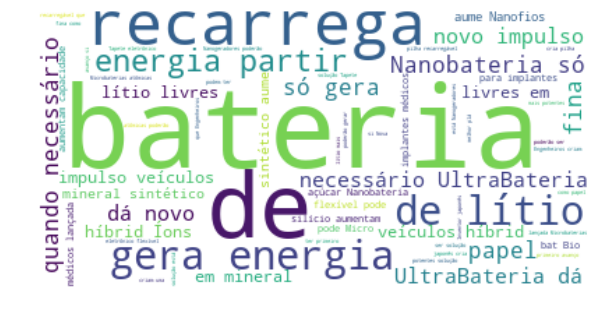

In [392]:
word_cloud_figure(df.title)

#### pygsheets

In [394]:
import pygsheets
from nltk.corpus import stopwords

def stop_words_gsheet():
    url = '/Users/liviaclarete/gdrive/code/functions/gdocs/googleKey_pesq7/client_secret.json'
    # reading stopwords from a google sheet
    gc = pygsheets.authorize(client_secret=url)
    # Open spreadsheet and then workseet
    sh = gc.open('stopwords_pt')
    wks = sh.sheet1
    # get the values
    stopwords_m = wks.get_all_values(returnas='matrix')
    # create a list with stopwords
    sheet_stopwords = [i[0] for i in stopwords_m]
    # loading nltk stopwords
    stop = stopwords.words('portuguese')
    stopwords_total = stop + sheet_stopwords
    return(stop)

In [395]:
# https://docs.google.com/spreadsheets/d/1GLMt63E9a-EdT-_igqXDvrLb4tf64bW_LTRLSFP2JbQ/edit#gid=1713228162

In [396]:
stwords = stop_words_gsheet()

In [397]:
stwords = stwords + ['do', 'no', 'a', 'o', 'com', 'por', 'em', 'de', 'sobre', 'diz', 'da', 'é', 'como', 'que', 'dentro', 'Após', 'diz', 'Entenda', 'dentro', 'ainda']

In [398]:
stwords[0]

'de'

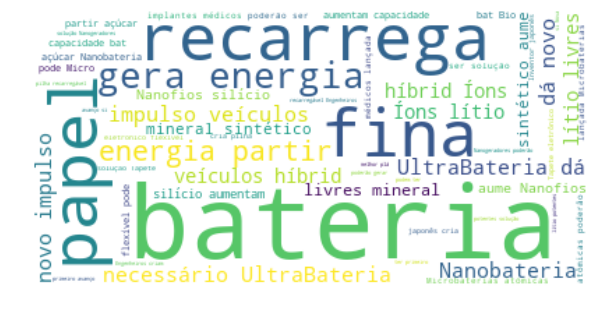

In [399]:
word_cloud_figure(df.title, stopwords=stwords)

### pre-processing

In [406]:
stwords = stwords

In [403]:
def pre_processing_col(col, stopwords=stwords):
    # transform the words into lower case
    col = col.apply(lambda x: x.lower())
    # removing punctuation
    col = col.str.replace('[^\w\s]', '')
    # removing numbers
    col = col.apply(
    # iterate through each item in a returns a list of words and joins the split words into a sentence again
    lambda x:' '.join([x for x in x.split() if not x.isdigit()]))
    # stopwords
    # removing stopwords
    col = col.apply(lambda x: ' '.join([x for x in x.split() if x not in stopwords]))
    return(col)

In [409]:
df['title_clean'] = pre_processing_col(df.title)

In [410]:
from textblob import TextBlob

# tokenize words from the text
def tokenization(col):
    serie = pd.Series(col.apply(lambda x:x.split()))
    return(serie)

In [412]:
df['token'] = tokenization(df.title_clean)

In [413]:
df.head()

,data,title,title_clean,token
0,04/04/2008,Nanobateria só gera energia quando necessário,nanobateria gera energia necessário,"[nanobateria, gera, energia, necessário]"
1,25/01/2008,UltraBateria dá novo impulso a veículos híbrid...,ultrabateria dá novo impulso veículos híbridoe...,"[ultrabateria, dá, novo, impulso, veículos, hí..."
2,09/01/2008,Íons de lítio livres em mineral sintético aume...,íons lítio livres mineral sintético aumentam c...,"[íons, lítio, livres, mineral, sintético, aume..."
3,27/12/2007,Nanofios de silício aumentam capacidade de bat...,nanofios silício aumentam capacidade baterias ...,"[nanofios, silício, aumentam, capacidade, bate..."
4,24/08/2007,Bio-bateria gera energia a partir de açúcar,biobateria gera energia partir açúcar,"[biobateria, gera, energia, partir, açúcar]"


In [414]:
import gensim
from gensim import corpora


# Creating a term dictionary of the text corpus
dictionary = corpora.Dictionary(df['token'])

In [415]:
# creating a Document Text Matrix with the dictionary
doc_term_matrix = [dictionary.doc2bow(i) for i in df['token'] ]


In [416]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=3, 
                random_state=100)

In [417]:
# Printing the topics
lda_model.print_topics()

[(0,
  '0.068*"baterias" + 0.050*"lítio" + 0.049*"capacidade" + 0.049*"aumentam" + 0.048*"livres" + 0.048*"mineral" + 0.048*"sintético" + 0.048*"íons" + 0.027*"ter" + 0.025*"primeiro"'),
 (1,
  '0.046*"bateria" + 0.043*"poderão" + 0.029*"energia" + 0.028*"partir" + 0.028*"fina" + 0.028*"recarrega" + 0.028*"humano" + 0.028*"gerar" + 0.027*"nanogeradores" + 0.027*"movimento"'),
 (2,
  '0.066*"baterias" + 0.044*"flexível" + 0.044*"lítio" + 0.040*"energia" + 0.039*"nanobateria" + 0.039*"gera" + 0.023*"papel" + 0.022*"capacidade" + 0.022*"recarrega" + 0.022*"ser"')]

In [418]:
import pyLDAvis
import pyLDAvis.gensim

# Downalod dictionaries from spacy -- lemmatization
# !python -m spacy download en # one time run
# !python -m spacy download pt # one time run

import matplotlib.pyplot as plt
import seaborn as sns

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

/Users/liviaclarete/.pyenv/versions/dataAnalysis/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.203111 -0.043680       1        1  41.908554
1      0.167497 -0.079066       2        1  34.305580
0      0.035614  0.122746       3        1  23.785862, topic_info=     Category       Freq            Term      Total  loglift  logprob
term                                                                 
13    Default  11.000000          livres  11.000000  30.0000  30.0000
15    Default  11.000000         mineral  11.000000  29.0000  29.0000
16    Default  11.000000       sintético  11.000000  28.0000  28.0000
17    Default  11.000000            íons  11.000000  27.0000  27.0000
14    Default  29.000000           lítio  29.000000  26.0000  26.0000
12    Default  20.000000      capacidade  20.000000  25.0000  25.0000
10    Default  20.000000        aumentam  20.000000  24.0000  24.0000
25    Default  18.000000        flexível  18.000000  23.0000  23.0000
54    Default  19.000000         bateria  19.000000  22.0000  22.0000
37    Default  19.000000         poderão  19.000000  21.0000  21.0000
11    Default  47.000000        baterias  47.000000  20.0000  20.0000
63    Default   9.000000          humano   9.000000  19.0000  19.0000
62    Default   9.000000           gerar   9.000000  18.0000  18.0000
65    Default   9.000000   nanogeradores   9.000000  17.0000  17.0000
64    Default   9.000000       movimento   9.000000  16.0000  16.0000
61    Default   9.000000           corpo   9.000000  15.0000  15.0000
74    Default   9.000000        segundos   9.000000  14.0000  14.0000
73    Default   9.000000            nova   9.000000  13.0000  13.0000
72    Default  10.000000             ter  10.000000  12.0000  12.0000
1     Default  19.000000            gera  19.000000  11.0000  11.0000
50    Default   9.000000         japonês   9.000000  10.0000  10.0000
2     Default  19.000000     nanobateria  19.000000   9.0000   9.0000
47    Default   9.000000            cria   9.000000   8.0000   8.0000
53    Default   9.000000            água   9.000000   7.0000   7.0000
49    Default   9.000000        inventor   9.000000   6.0000   6.0000
51    Default   9.000000           pilha   9.000000   5.0000   5.0000
70    Default  10.000000        primeiro  10.000000   4.0000   4.0000
48    Default   9.000000        funciona   9.000000   3.0000   3.0000
67    Default  10.000000          avanço  10.000000   2.0000   2.0000
52    Default   9.000000    recarregável   9.000000   1.0000   1.0000
...       ...        ...             ...        ...      ...      ...
16     Topic3  11.032059       sintético  11.791636   1.3695  -3.0300
17     Topic3  10.983362            íons  11.782627   1.3658  -3.0345
72     Topic3   6.196723             ter  10.923843   0.8692  -3.6068
12     Topic3  11.173371      capacidade  20.641747   0.8223  -3.0173
10     Topic3  11.111062        aumentam  20.630753   0.8172  -3.0229
70     Topic3   5.624253        primeiro  10.821035   0.7817  -3.7038
67     Topic3   5.110847          avanço  10.729219   0.6945  -3.7995
71     Topic3   5.037864   significativo  10.716059   0.6813  -3.8139
68     Topic3   4.719246          pilhas  10.658991   0.6213  -3.8792
35     Topic3   4.558282        atômicas  10.629626   0.5894  -3.9139
31     Topic3   4.445906       implantes  10.570366   0.5700  -3.9389
36     Topic3   4.395940   microbaterias  10.600824   0.5558  -3.9502
39     Topic3   4.337260        sensores  10.590378   0.5434  -3.9636
66     Topic3   4.321859            anos  10.587242   0.5401  -3.9672
30     Topic3   4.294813  comercialmente  10.540377   0.5383  -3.9734
34     Topic3   4.293539         médicos  10.543920   0.5376  -3.9737
32     Topic3   4.277481         lançada  10.538637   0.5344  -3.9775
14     Topic3  11.334422           lítio  29.497208   0.4796  -3.0030
33     Topic3   3.963027    microbateria  10.484272   0.4632  -4.0538
56     Topic3   3.780062     engenheiros  10.48